# Desafio - Analisando o preço de combustíveis

Nos últimos meses a alta da Gasolina tem impactado a vida de muitos consumidores

Com isso precisamos saber:

1. No ano de 2021, qual o maior valor da gasolina por estado?

2. Gere um gráfico em barras da média de valor da gasolina pôr mês em 2021.

3. No mês 04/2021, identifique qual(ais) as cidade(s) que abastecer com etanol é mais vantajaso do que gasolina?

OBS: Para saber se o etanol é mais vantajoso, basta dividir o preço do litro do etanol pelo da gasolina. Se o resultado for inferior a 0,7, o etanol r é o melhor para abastecer. Se for maior que 0,7, então a gasolina é melhor.

Dicas:

Use urllib.request: Essa Biblioteca é para baixar a base de dados, caso necessário

Use pandas: O Pandas é uma biblioteca do Python muito utilizada para análise de dados. Com ele podemos ler nossos dados, e começar a manipular, transformar e limpar, caso necessário.

In [1]:
# A - Série histórica de preços de combustíveis - 
# revenda - Conjuntos de dados - Portal Brasileiro de Dados Abertos 
url = "https://dados.gov.br/dataset/serie-historica-de-precos-de-combustiveis-por-revenda"

### Importações

In [2]:
from bs4 import BeautifulSoup

In [3]:
from datetime import datetime

In [4]:
import pandas as pd

In [5]:
import requests

In [6]:
import os

### Pegar as URI dos arquivos Etanol + Gasolina

Foi nescessario baixar a cadeia de certificado SSL por causa de um erro de verificação ao acessar a pagina atraves do python

Foram colocados na pasta **certificados**.

In [7]:
resp = requests.get(url=url, verify="certificados/dados-gov-br-chain.pem")

In [8]:
resp.status_code

200

In [9]:
soup = BeautifulSoup(resp.text, 'lxml')

In [10]:
links = soup.find_all('a', class_='resource-url-analytics')

In [11]:
# href com 2 urls junta, foi pego apenas do arquivo
uri_all = map(lambda a: a.get('href').split('?url=')[-1], links)

In [12]:
uris = filter(lambda x: 'etanol' in x and '2021' in x, uri_all)

In [13]:
def download_file(url: str):
    filename = url.split('/')[-1]

    if not os.path.isdir('data'):
        os.mkdir('data')
    
    response = requests.get(url)
    if response.status_code == 200:

        with open(f'data/{filename}', 'wb') as f:
            f.write(response.content) 
            return f'Download {filename}: OK'

    return f'Download {filename}: FAIL'

In [14]:
for uri in uris:
    print(download_file(uri))

Download dados-abertos-precos-2021-01-gasolina-etanol.csv: FAIL
Download 2021-02-gasolina-etanol.csv: OK
Download 2021-03-gasolina-etanol.csv: OK
Download 2021-04-gasolina-etanol.csv: OK
Download 2021-05-gasolina-etanol-1.csv: OK
Download 2021-06-gasolina-etanol.csv: OK
Download 2021-07-gasolina-etanol.csv: OK


O link do arquvo do mes de janeiro esta quebrado

### Concatenado Dataframes

In [15]:
pd.set_option("display.precision", 2)

In [16]:
dtype = {
    'Região - Sigla': 'object',
    'Estado - Sigla': 'object', 
    'Município': 'object',
    'Revenda': 'object',
    'CNPJ da Revenda': 'object', 
    'Nome da Rua':'object',
    'Número Rua': 'object',
    'Complemento': 'object',
    'Bairro': 'object',
    'Cep': 'object',
    'Produto': 'object',
    'Valor de Venda': 'float32',
    'Valor de Compra': 'float32',
    'Unidade de Medida': 'object',
    'Bandeira': 'object'
}

In [17]:
files = filter(lambda x: '.csv' in x, os.listdir('data'))

In [18]:
df_concat = pd.concat([pd.read_csv(f'data/{filename}', sep=';') for filename in files])

In [19]:
len(df_concat)

251420

In [20]:
df_concat['Valor de Venda'] = df_concat['Valor de Venda'].map(lambda x: x.replace(',', '.'))

In [21]:
df_concat['Data da Coleta'] = df_concat['Data da Coleta'].map(lambda x: datetime.strptime(x, '%d/%m/%Y'))

In [22]:
df_concat = df_concat.astype(dtype=dtype)

### Tratar Valores Nulos e NaN

Não foi tratados os campos nulos, pois não são utilizados

In [23]:
df_concat.isna().sum()

Região - Sigla            0
Estado - Sigla            0
Município                 0
Revenda                   0
CNPJ da Revenda           0
Nome da Rua               0
Número Rua              116
Complemento          200239
Bairro                  536
Cep                       0
Produto                   0
Data da Coleta            0
Valor de Venda            0
Valor de Compra      251420
Unidade de Medida         0
Bandeira                  0
dtype: int64

### 01 - No ano de 2021, qual o maior valor da gasolina por estado?

In [24]:
df_concat.Produto.unique()

array(['GASOLINA ADITIVADA', 'ETANOL', 'GASOLINA'], dtype=object)

In [25]:
df_gasolina = df_concat[df_concat['Produto'] == 'GASOLINA']

In [26]:
df_desafio_01 = df_gasolina[['Estado - Sigla', 'Valor de Venda']].rename(
                            columns={'Estado - Sigla': 'UF', 'Valor de Venda':'VALOR'})

In [27]:
df_desafio_01.groupby('UF').max()

,VALOR
UF,
AC,6.99
AL,6.60
AM,6.05
AP,5.70
BA,6.50
CE,6.35
DF,6.30
ES,6.91
GO,6.65


### 02 - Gere um gráfico em barras da média de valor da gasolina pôr mês em 2021.

In [28]:
df_desario_02 = df_gasolina[['Data da Coleta', 'Valor de Venda']]

In [29]:
df_gp = df_desario_02.groupby(pd.Grouper(key='Data da Coleta', axis=0, freq='M')).mean()

In [30]:
# Troca a data pelas 3 primeiras letras do nome do mes
df_gp.index = df_gp.index.map(lambda x: str(x.month_name())[:3])

In [31]:
df_gp

,Valor de Venda
Data da Coleta,
Feb,4.91
Mar,5.47
Apr,5.45
May,5.58
Jun,5.67
Jul,5.80


In [32]:
bar_conf = {
    'title': 'Media do preço da Gasolina por Mês em 2021',
    'xlabel': 'Mês',
    'ylabel': 'Media de Preço',
    'ylim': [0,10],
    'rot': 0,
    'figsize': (15, 5),
}

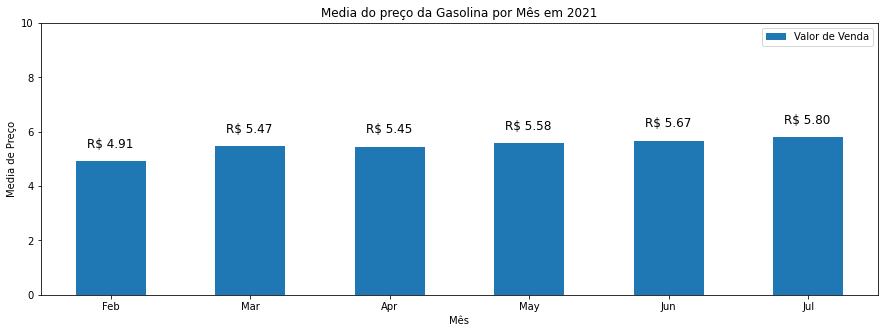

In [33]:
ax = df_gp.plot.bar(**bar_conf)

for i, v in enumerate(df_gp['Valor de Venda']):
    ax.text(i-0.17, v+0.5, 'R$ %.2f' % v, fontsize=12)

### 02 - No mês 04/2021, identifique qual(ais) as cidade(s) que abastecer com etanol é mais vantajaso do que gasolina?

In [34]:
df_apr = df_concat[df_concat['Data da Coleta'].dt.month == 4]

In [35]:
df_slc = df_apr[df_apr['Produto'] != 'GASOLINA ADITIVADA'][['Município', 'Produto', 'Valor de Venda']]

In [36]:
df_slc.groupby(['Município', 'Produto']).mean()

Valor de Venda
Município              Produto                 
ADAMANTINA             ETANOL              3.64
                       GASOLINA            5.32
ALENQUER               GASOLINA            6.00
ALVORADA               ETANOL              5.72
                       GASOLINA            5.81
...                                         ...
VITORIA DE SANTO ANTAO GASOLINA            5.37
VOLTA REDONDA          ETANOL              5.01
                       GASOLINA            6.15
VOTORANTIM             ETANOL              3.58
                       GASOLINA            5.18

[461 rows x 1 columns]

In [37]:
gp_etanol = df_slc[df_slc['Produto'] == 'ETANOL'].groupby('Município').mean()

In [38]:
gp_gasolina = df_slc[df_slc['Produto'] == 'GASOLINA'].groupby('Município').mean()

In [39]:
print('CIDADES QUE O ETANOL É MAIS VANTAJOSO - 04/2021')
print('===============================')

for key in gp_etanol.index:
    if gp_etanol['Valor de Venda'][key] / gp_gasolina['Valor de Venda'][key] < 0.7:
        print('Municipio: %s' % key.title())
        print('Valor: R$ %.2f' % gp_etanol['Valor de Venda'][key])
        print('===============================')


CIDADES QUE O ETANOL É MAIS VANTAJOSO - 04/2021
Municipio: Adamantina
Valor: R$ 3.64
Municipio: Aparecida De Goiania
Valor: R$ 3.97
Municipio: Aracatuba
Valor: R$ 3.48
Municipio: Araguari
Valor: R$ 3.92
Municipio: Araraquara
Valor: R$ 3.59
Municipio: Araras
Valor: R$ 3.53
Municipio: Assis
Valor: R$ 3.49
Municipio: Atibaia
Valor: R$ 3.70
Municipio: Barretos
Valor: R$ 3.50
Municipio: Barueri
Valor: R$ 3.55
Municipio: Bauru
Valor: R$ 3.44
Municipio: Bebedouro
Valor: R$ 3.64
Municipio: Belo Horizonte
Valor: R$ 3.88
Municipio: Betim
Valor: R$ 3.86
Municipio: Birigui
Valor: R$ 3.69
Municipio: Campinas
Valor: R$ 3.64
Municipio: Carapicuiba
Valor: R$ 3.57
Municipio: Catanduva
Valor: R$ 3.70
Municipio: Contagem
Valor: R$ 3.89
Municipio: Cotia
Valor: R$ 3.66
Municipio: Cruzeiro
Valor: R$ 3.75
Municipio: Cuiaba
Valor: R$ 3.54
Municipio: Diadema
Valor: R$ 3.61
Municipio: Embu Das Artes
Valor: R$ 3.69
Municipio: Franca
Valor: R$ 3.73
Municipio: Frutal
Valor: R$ 4.03
Municipio: Goiania
Valor: R$ 3.9